#Classification Predict

##Problem statement

###Background
Many companies are built around lessening one’s environmental impact or carbon footprint. They offer products and services that are environmentally friendly and sustainable, in line with their values and ideals. They would like to determine how people perceive climate change and whether or not they believe it is a real threat.

### Problem Statement
Create a Machine Learning model that is able to classify whether or not a person believes in climate change, based on their novel tweet data.

## Importing the libraries

In [503]:
# Analysis Libraries
import pandas as pd
import numpy as np
from collections import Counter

# Visualisation Libraries
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

# Language Processsing Libraries
import nltk
nltk.download(['punkt','stopwords'])
nltk.download('vader_lexicon')
nltk.download('popular')
from sklearn.utils import resample
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.tokenize import word_tokenize, TreebankWordTokenizer 
import re
import string
from nltk import SnowballStemmer
import spacy

# ML Libraries
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC,SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,recall_score,precision_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from nltk import SnowballStemmer

# Code for hiding seaborn warnings
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[

## Load Data

X_df DataFrame contains three columns; sentiment, message and tweetid

In [504]:
X_df = pd.read_csv('train.csv')
X_df.head(5)

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


In [505]:
# inspect structure of dataset
X_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15819 entries, 0 to 15818
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  15819 non-null  int64 
 1   message    15819 non-null  object
 2   tweetid    15819 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 370.9+ KB


## Exploratory Data Analysis

A check for uniqueness indicates that the message column has over 1000 duplicates due to repeated tweetids. This should be removed as to not train the model on repeated data.


In [506]:
number_of_unique=[X_df[i].nunique() for i in X_df.columns]
column_names=[i for i in X_df.columns]
unique_zip=list(zip(column_names,number_of_unique))
unique_df=pd.DataFrame(unique_zip,columns=['Column_Feature','Unique_Values'])
unique_df

,Column_Feature,Unique_Values
0,sentiment,4
1,message,14229
2,tweetid,15819


In [507]:
# A function to remove duplicate rows from the message column

def delete_dup(df):
  df=df.copy()
  df = df.drop_duplicates(subset='message') #messges specified as subset to evaluate
  return df

In [508]:
X_df=delete_dup(X_df)

In [509]:
# Recheck for duplicates
number_of_unique=[X_df[i].nunique() for i in X_df.columns]
unique_df=pd.DataFrame(unique_zip,columns=['Column_Feature','Unique_Values'])
unique_df

,Column_Feature,Unique_Values
0,sentiment,4
1,message,14229
2,tweetid,15819


In order to give our graphs more context, we have added the text version of the sentiment to the train DataFrame. These new columns will be deleted as they do not assist in the actual classification problem.

In [510]:
# A function to add the text version of 'sentiment'. This is just for graphing purposes
# and should be droped.
def add_text_sent(df):
    # Copy the input DataFrame
    out_df = df.copy()
    
    sentiment_text = []
    
    # Loop though the sentiments and assign the text version. 
    # Pro: 1, News: 2, Neutral: 0, Anti: -1
    for sent in df['sentiment']:
        
        if sent == 1:
            sentiment_text.append('Pro')
            
        elif sent == 2:
            sentiment_text.append('News')
            
        elif sent == 0:
            sentiment_text.append('Neutral')
            
        elif sent == -1:
            sentiment_text.append('Anti')
            
    out_df['sentiment_text'] = sentiment_text
    
    out_df.drop(['message', 'tweetid'], axis = 1, inplace = True)
        
    return out_df

In [511]:
# Function to arrange the DataFrame to show percentage of classes
def class_table(df):
    out_df = df.groupby(['sentiment_text']).count()
    
    class_perc = [round(100 * x / len(df), 1) for x in out_df['sentiment']]
    
    out_df['% of Total Classes'] = class_perc
    
    return out_df

In [512]:
# Create a new DataFrame for graphing purposes. Show the sentiment classes as a 
# percentage.
new_X_df = add_text_sent(X_df)
new_X_df_t = class_table(new_X_df)
new_X_df_t

,sentiment,% of Total Classes
sentiment_text,,
Anti,1221,8.6
Neutral,2244,15.8
News,3542,24.9
Pro,7222,50.8


The class labels of the training data are not balanced. As shown in the table above, most of the tweets (50.8%) are classified as `Pro`, which in the context of the `Problem Statement` means they believe in man-made climate change. The other classes (`News`, `Neutral` and `Anti`) account for `24.9%`, `15.8%` and `8.6%`respectively. This presents a challenge in that the models developed might have a bias in classifying tweets. To further illustrate this distribution, a bar graph of the count of each sentiment class is shown below: 

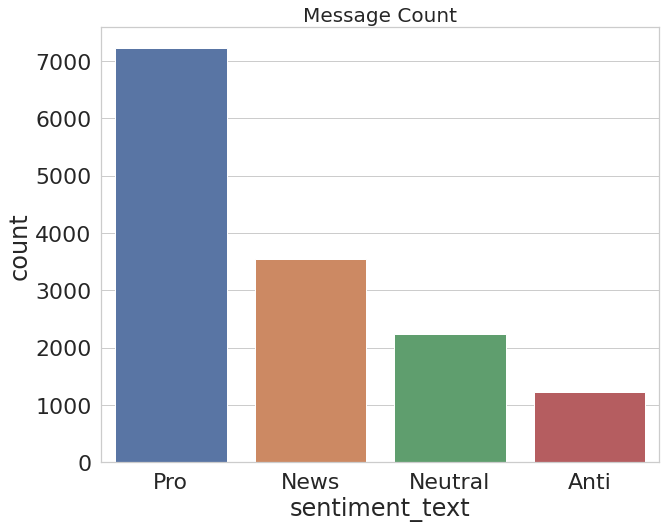

In [513]:
# Show the ditribution of the classes as a graph
f, ax = plt.subplots(figsize=(10, 8))
sns.set(style="whitegrid")
ax = sns.countplot(x="sentiment_text", data=new_X_df)
plt.title('Message Count', fontsize =20)
plt.show()

#### Length of Tweets per Sentiment Class 

In [514]:
# Add a column of length of tweets. 
new_X_df['message_length'] = X_df['message'].str.len()
new_X_df.head()

,sentiment,sentiment_text,message_length
0,1,Pro,140
1,1,Pro,62
2,2,News,140
3,1,Pro,99
4,1,Pro,122


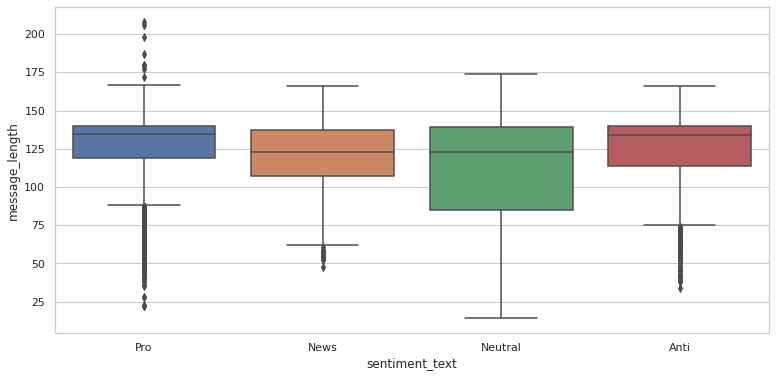

In [515]:
# Display the boxplot of the length of tweets.
plt.figure(figsize=(12.8,6))
sns.boxplot(data=new_X_df, x='sentiment_text', y='message_length');

The Tweets seem to be around `125` characters loong on average. This is shown by both the mean of the classes in the boxplots above and distribution density of the classes below. All the classes have a distribution density centred around `125` characters. 

The length of `Neutral` Tweets seem to have a wider range and `Pro` Tweets have a shorter range. The `Pro` Tweets also seem to have a lot of `outliers` by this measurement.

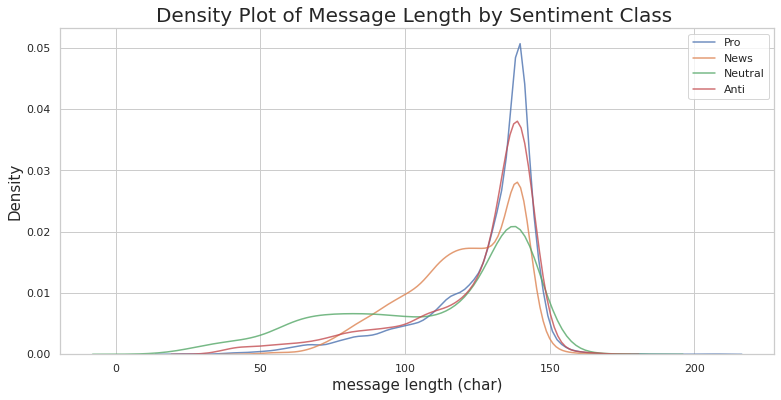

In [516]:

# Plot of distribution of scores for building categories
plt.figure(figsize=(12.8,6))

    
# Density plot of Energy Star scores
sns.kdeplot(new_X_df[new_X_df['sentiment_text'] == 'Pro']['message_length'], label = 'Pro', shade = False, alpha = 0.8);
sns.kdeplot(new_X_df[new_X_df['sentiment_text'] == 'News']['message_length'], label = 'News', shade = False, alpha = 0.8);
sns.kdeplot(new_X_df[new_X_df['sentiment_text'] == 'Neutral']['message_length'], label = 'Neutral', shade = False, alpha = 0.8);
sns.kdeplot(new_X_df[new_X_df['sentiment_text'] == 'Anti']['message_length'], label = 'Anti', shade = False, alpha = 0.8);

# label the plot
plt.xlabel('message length (char)', size = 15); plt.ylabel('Density', size = 15); 
plt.title('Density Plot of Message Length by Sentiment Class ', size = 20);

## Data Preprocessing

Text data needs to be pre-processed efore modelling. Steps taken include

1.   Removing of replacing certain text
2. Tokenization and lemmatization of text

**Clean Text Data**

In [517]:
# Function to remove/replace unwanted text such as characters,URLs etc

def clean(text):

  text=text.replace("'",'')
  text=text.replace(".",' ')
  text=text.replace("  ",'')
  text=text.replace(",",' ')
  text=text.replace("_",' ')
  text=text.replace("!",' ')
  text=text.replace("RT",'retweet') #Replace RT(Retweet) with relay
  text=text.replace(r'\d+','')
  text=re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(https?//[^\s]+))','weblink',text)
  text=re.sub('((co/[^\s]+)|(co?://[^\s]+)|(co?//[^\s]+))','',text)
  text=text.lower()  # Lowercase tweet
  text =text.lstrip('\'"') # Remove extra white space
  
  return text

Punctuation at the beginning and end of words can be removed

In [518]:
#Function 3
def rm_punc(text):
  
  clean_text=[]
  for i in str(text).split():
    rm=i.strip('\'"?,.:_/<>!')
    clean_text.append(rm)
  return ' '.join(clean_text)

In [519]:
X_df['message']=X_df['message'].apply(clean)
X_df['message']=X_df['message'].apply(rm_punc)
X_df.head(5)

,sentiment,message,tweetid
0,1,polyscimajor epa chief doesnt think carbon dio...,625221
1,1,its not like we lack evidence of anthropogenic...,126103
2,2,retweet @rawstory researchers say we have thre...,698562
3,1,#todayinmaker# wired 2016 was a pivotal year ...,573736
4,1,retweet @soynoviodetodas its 2016 and a racist...,466954


Furthermore, the @ and # must be dealt with by replacing at with @ and removing #


In [520]:
# Function replaces the @ symbol with the word at

def at(text):
 
  return ' '.join(re.sub("(@+)","at ",text).split())

In [521]:
# Function replaces the # symbol with the word tag

def hashtag(text):

  return ' '.join(re.sub("(#+)"," tag ",text).split())

In [522]:
#remove hashtags and replace @
X_df['message']=X_df['message'].apply(at)
X_df['message']=X_df['message'].apply(hashtag)
X_df.head(5)

,sentiment,message,tweetid
0,1,polyscimajor epa chief doesnt think carbon dio...,625221
1,1,its not like we lack evidence of anthropogenic...,126103
2,2,retweet at rawstory researchers say we have th...,698562
3,1,tag todayinmaker tag wired 2016 was a pivotal ...,573736
4,1,retweet at soynoviodetodas its 2016 and a raci...,466954


**Tokenize and Lemmatization**

Split tweets into individual words via tokenization in the tokens column.

In [523]:
# Tokenise each tweet messge

tokeniser = TreebankWordTokenizer()
X_df['tokens'] = X_df['message'].apply(tokeniser.tokenize)
X_df.head(5)

,sentiment,message,tweetid,tokens
0,1,polyscimajor epa chief doesnt think carbon dio...,625221,"[polyscimajor, epa, chief, doesnt, think, carb..."
1,1,its not like we lack evidence of anthropogenic...,126103,"[its, not, like, we, lack, evidence, of, anthr..."
2,2,retweet at rawstory researchers say we have th...,698562,"[retweet, at, rawstory, researchers, say, we, ..."
3,1,tag todayinmaker tag wired 2016 was a pivotal ...,573736,"[tag, todayinmaker, tag, wired, 2016, was, a, ..."
4,1,retweet at soynoviodetodas its 2016 and a raci...,466954,"[retweet, at, soynoviodetodas, its, 2016, and,..."


Perform Lemmatization of tokens to group together the different inflected forms of a word so they can be analysed as a single item

In [524]:
# Function performs lemmatization in the tokens column

def lemma(text):
  lemma = WordNetLemmatizer() 
  return [lemma.lemmatize(i) for i in text]


Generate Lemmatization column

In [525]:
X_df['lemma'] =X_df['tokens'].apply(lemma)
X_df.head(5)

,sentiment,message,tweetid,tokens,lemma
0,1,polyscimajor epa chief doesnt think carbon dio...,625221,"[polyscimajor, epa, chief, doesnt, think, carb...","[polyscimajor, epa, chief, doesnt, think, carb..."
1,1,its not like we lack evidence of anthropogenic...,126103,"[its, not, like, we, lack, evidence, of, anthr...","[it, not, like, we, lack, evidence, of, anthro..."
2,2,retweet at rawstory researchers say we have th...,698562,"[retweet, at, rawstory, researchers, say, we, ...","[retweet, at, rawstory, researcher, say, we, h..."
3,1,tag todayinmaker tag wired 2016 was a pivotal ...,573736,"[tag, todayinmaker, tag, wired, 2016, was, a, ...","[tag, todayinmaker, tag, wired, 2016, wa, a, p..."
4,1,retweet at soynoviodetodas its 2016 and a raci...,466954,"[retweet, at, soynoviodetodas, its, 2016, and,...","[retweet, at, soynoviodetodas, it, 2016, and, ..."


Lastly a new column derived from the lemma column can be generate in order to train the model/s

In [526]:
# Insert new clean message column
X_df['clean message'] = X_df['lemma'].apply(lambda i: ' '.join(i))
X_df.head(5)

,sentiment,message,tweetid,tokens,lemma,clean message
0,1,polyscimajor epa chief doesnt think carbon dio...,625221,"[polyscimajor, epa, chief, doesnt, think, carb...","[polyscimajor, epa, chief, doesnt, think, carb...",polyscimajor epa chief doesnt think carbon dio...
1,1,its not like we lack evidence of anthropogenic...,126103,"[its, not, like, we, lack, evidence, of, anthr...","[it, not, like, we, lack, evidence, of, anthro...",it not like we lack evidence of anthropogenic ...
2,2,retweet at rawstory researchers say we have th...,698562,"[retweet, at, rawstory, researchers, say, we, ...","[retweet, at, rawstory, researcher, say, we, h...",retweet at rawstory researcher say we have thr...
3,1,tag todayinmaker tag wired 2016 was a pivotal ...,573736,"[tag, todayinmaker, tag, wired, 2016, was, a, ...","[tag, todayinmaker, tag, wired, 2016, wa, a, p...",tag todayinmaker tag wired 2016 wa a pivotal y...
4,1,retweet at soynoviodetodas its 2016 and a raci...,466954,"[retweet, at, soynoviodetodas, its, 2016, and,...","[retweet, at, soynoviodetodas, it, 2016, and, ...",retweet at soynoviodetodas it 2016 and a racis...


##Text Analysis

The words most popular amongst the sentiment groups can be represented visually

**Word Clouds**

The strings generated for each sentiment class will provide the information used to generate the wordclouds for each class

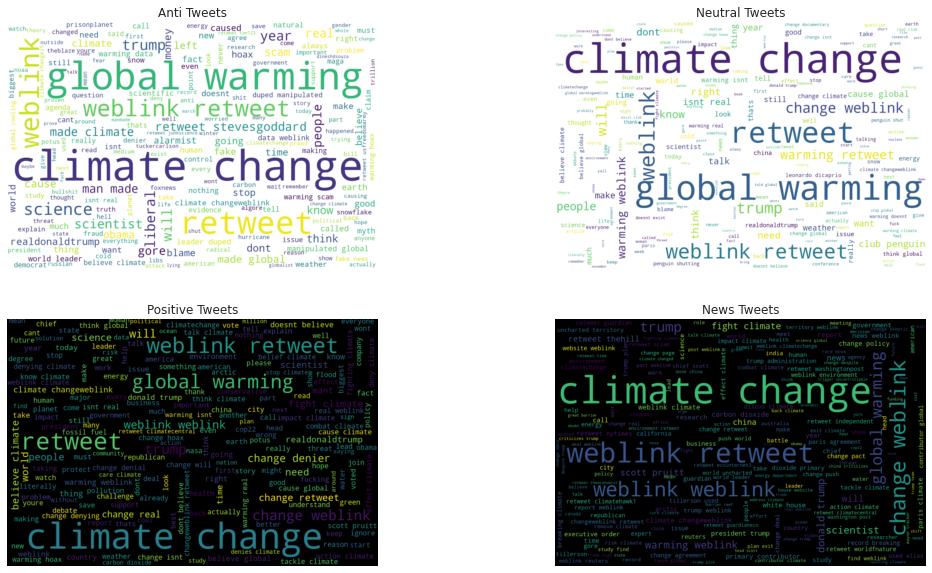

In [527]:
# Create and generate a word cloud image:
wordcloud = WordCloud(width=1500, height = 900).generate(X_df['message'][0])

# Display the generated image:
fig, axs = plt.subplots(2, 2, figsize=(18,10))

anti_wordcloud = WordCloud(width=1800, height = 1200,background_color="white").generate(' '.join(i for i in word_df[word_df['sentiment']==-1]['wordcloud']))
axs[0, 0].imshow(anti_wordcloud, interpolation='bilinear')
axs[0, 0].set_title('Anti Tweets')
axs[0, 0].axis('off')
neutral_wordcloud = WordCloud(width=1800, height = 1200,background_color="white").generate(' '.join(i for i in word_df[word_df['sentiment']==0]['wordcloud']))
axs[0, 1].imshow(neutral_wordcloud, interpolation='bilinear')
axs[0, 1].set_title('Neutral Tweets')
axs[0, 1].axis('off')
positive_wordcloud = WordCloud(width=1800, height = 1200).generate(' '.join(i for i in word_df[word_df['sentiment']==1]['wordcloud']))
axs[1, 0].imshow(positive_wordcloud, interpolation='bilinear')
axs[1, 0].set_title('Positive Tweets')
axs[1, 0].axis('off')
news_wordcloud = WordCloud(width=1800, height = 1200).generate(' '.join(i for i in word_df[word_df['sentiment']==2]['wordcloud']))
axs[1, 1].imshow(news_wordcloud, interpolation='bilinear')
axs[1, 1].set_title('News Tweets')
axs[1, 1].axis('off')

plt.show()

From the word clouds it is clear that all groups speak about climate change and global warming as expected. The word clouds of each group however contain information that echo their sentiment.

1.   The Anti cloud contains words such as fake, man made and scam
2.   The Positive cloud contains words such as real, believe and change
3.   The Neutral cloud contains a mixture of words that could lean either to anti or positive
4.   The News cloud contains words and names such as Trump, Scott Pruitt (Administrator of the United States Environmental Protection Agency) and change policy


**Named Entity Recognition**

Futhermore, it can be seen which people and organisations are refered in tweets using NER

In [528]:
#Spacy will be used to generate entities
nlp = spacy.load('en_core_web_sm')

In [529]:
# A new dataframe NER_df is created for the following visualisations
NER_df=pd.DataFrame(X_df['clean message'])

In [530]:
# Function generates docs to get Name Entity Recognitions

def doc(text):
  doc=nlp(text)
  return doc

In [531]:
# Create a new column containing the nlp transformed text
NER_df['doc']=NER_df['clean message'].apply(doc)

In [532]:
#Functions below extract Persons and organisations from the input parameter text. If entity is not found 'None' is populated in cell

def person(doc):
    if doc.ents:
        for ent in doc.ents:
          if ent.label_=='PERSON':
            return (ent.text)
    else:
      return ('None')

def org(doc):
    if doc.ents:
        for ent in doc.ents:
          if ent.label_=='ORG':
            return (ent.text)
    else:
      return ('None')

In [533]:
# Generate new columns 'persons' and 'organisation'

NER_df['persons']=NER_df['doc'].apply(person)
NER_df['organisation']=NER_df['doc'].apply(org)

Below are the plots for the top persons and organisations tweeted about

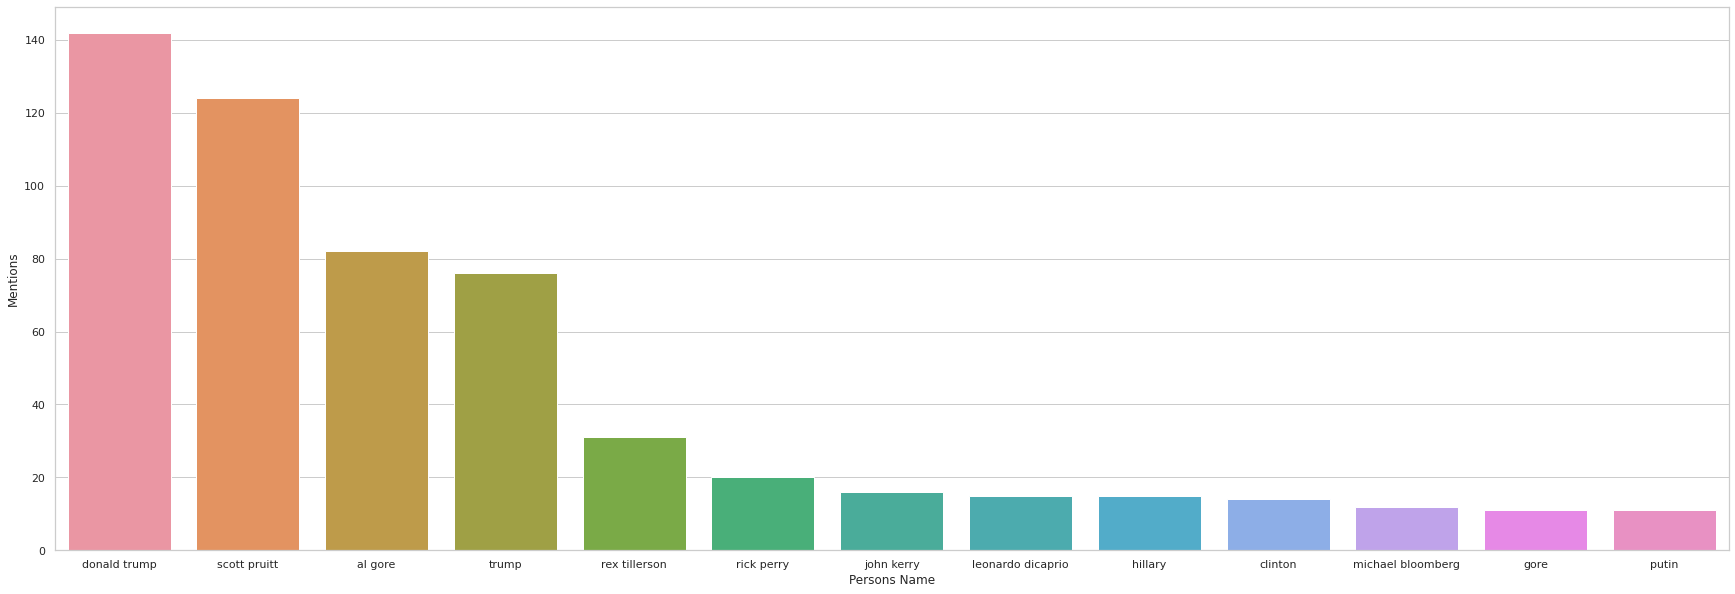

In [534]:
#Retrive all the PERSON labels from the NER_df and generate a new dataframe person_df for analysis
persons=[i for i in NER_df['persons']]
person_counts = Counter(persons).most_common(20)
person_df=pd.DataFrame(person_counts,columns=['persons name','count'])
person_df.drop([0,1,7,8,13,15,16],axis=0,inplace=True) # rows removed due to 'None' entries, incorrect classification or different entry of a same entity (repetition)

#plot top persons tweeted
f, ax = plt.subplots(figsize=(30, 10))
sns.set(style='white',font_scale=1.2)
sns.barplot(x=person_df[person_df['count'] <1000].iloc[:,0],y=person_df[person_df['count'] <1000].iloc[:,1])
plt.xlabel('Persons Name') 
plt.ylabel('Mentions')   
plt.show()

As seen in the Persons of Interest, the people most tweeted about are prominent USA politicians such as Donald trump and Al Gore. 
Leonardo Dicaprio is also a popular figure tweeted about regarding climate change Although there is a misclassifications of doe(Department of Energy) 

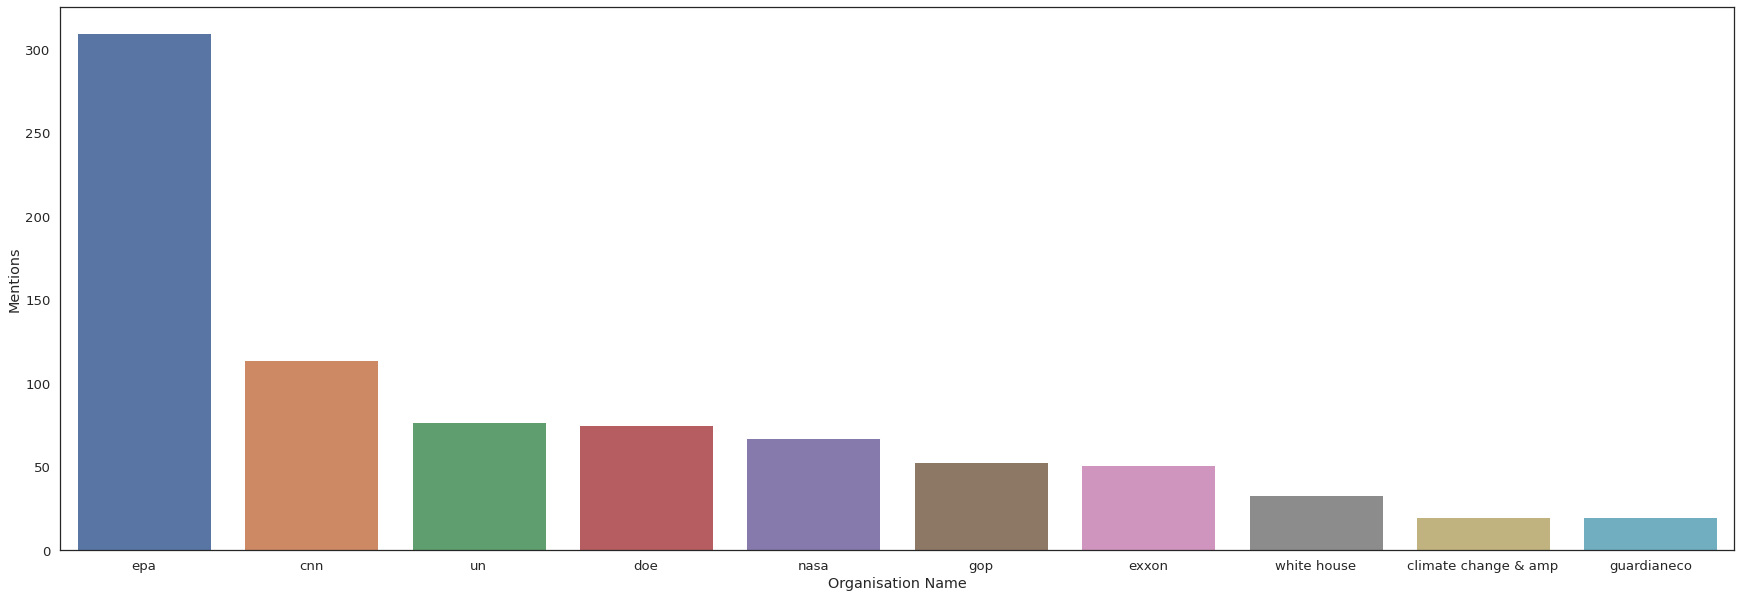

In [535]:
#Retrive all the ORG labels from the NER_df and generate a new dataframe org_df for analysis
org=[i for i in NER_df['organisation']]

org_counts = Counter(org).most_common(15)
org_df=pd.DataFrame(org_counts,columns=['organisation name','count'])
org_df.drop([0,1,3,8,12],axis=0,inplace=True) # rows removed due to 'None' entries, incorrect classification or different entry of a same entity (repetition)

#plot top organisations tweeted
f, ax = plt.subplots(figsize=(30, 10))
sns.set(style='white',font_scale=2)
org_bar=sns.barplot(x=org_df[org_df['count'] <1000].iloc[:,0],y=org_df[org_df['count'] <1000].iloc[:,1])
plt.xlabel('Organisation Name') 
plt.ylabel('Mentions')   
plt.show()

The are many organisations that are referenced in tweets but the epa (United States Environmental Protection Agency) is mentioned the most, followed well known organisations such as CNN (news) , the UN (ntergovernmental organization) and DOE( Department of Energy)

##Model Training and Testing

The Perparation of the data for modelling will require spliting of features and labels. In this instance, only the sentiment and clean message columns are required from X_df

Train/Test Split

X and y training features split from X_df


In [536]:
# Feature and label split 

X=X_df['clean message']
y=X_df['sentiment']

25% of data allocated to testing

In [537]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

SVC Classification with TfidfVectorization

Parameter Search performed using GridSearch.(Takes a while to run, output hardcopied in pipeline.Uncheck to run)

In [538]:
#pipeline = Pipeline([('tfidf', TfidfVectorizer()),('clf', SVC())])

#parameters = {
 #   'tfidf__max_df': (0.25, 0.5, 0.75),'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
   # 'tfidf__max_features':(500,2500,5000),'clf__C':(0.1,1,10),'clf__gamma':(1,0.1,0.001)}

#grid_search = GridSearchCV(pipeline, parameters, cv=2, n_jobs=2, verbose=3)
#grid_search.fit(X_train, y_train)

In [539]:
#grid_search.best_params_

In [540]:
#grid_predictions = grid_search.predict(X_test)

From the Gridsearch. The ideal parameters for SVC classification combined with TfidfVectoriztion is c=10 , gamma=1 , max_df=0.25 , max_features=5000 , ngram=(1,1)

Fitting model with optimized parameters

In [541]:
#Pipeline 

svc = Pipeline(
    [('tfidf', TfidfVectorizer(analyzer='word', max_df=0.75,max_features=5000,ngram_range=(1,1)))
    ,('clf', SVC(C=10,gamma=1))])

# Train model
model=svc.fit(X_train, y_train)

# Form a prediction set
predictions = model.predict(X_test)

In [542]:
# Print Results
#Confusion matrix
confusion = 'Confusion Matrix'.center(100, '*')
print(confusion)
matrix=confusion_matrix(y_test,predictions)
print(confusion_matrix(y_test,predictions))
print('')

#Classification report
report='Classification Report'.center(100,'*')
print(report)
print('')
print(classification_report(y_test,predictions))
print('')

#Model Performance
performance='Performance Metrics'.center(100,'*')
print(performance)
print('The model accuracy is :',accuracy_score(y_test,predictions))
print('The model recall is :',recall_score(y_test, predictions,average='weighted'))

F1 = 2 * (precision_score(y_test,predictions,average='weighted') * recall_score(y_test, predictions,average='weighted')) / (precision_score(y_test,predictions,average='weighted') + recall_score(y_test, predictions,average='weighted'))

print('The model F1score is : ',F1)

******************************************Confusion Matrix******************************************
[[ 105   40  154   12]
 [  23  184  311   42]
 [  19   77 1570  129]
 [   2    7  188  695]]

***************************************Classification Report****************************************

              precision    recall  f1-score   support

          -1       0.70      0.34      0.46       311
           0       0.60      0.33      0.42       560
           1       0.71      0.87      0.78      1795
           2       0.79      0.78      0.79       892

    accuracy                           0.72      3558
   macro avg       0.70      0.58      0.61      3558
weighted avg       0.71      0.72      0.70      3558


****************************************Performance Metrics*****************************************
The model accuracy is : 0.7178189994378864
The model recall is : 0.7178189994378864
The model F1score is :  0.7140773273071888


Save model as pickle

In [543]:
import pickle
model_save_path = "SVC.pkl"
with open(model_save_path,'wb') as file:
    pickle.dump(svc,file)

##Model Prediction on test.csv

Perform data cleaning as done before on the test dataframe from test.csv

In [544]:
#import tes.csv

test=pd.read_csv('test.csv')

FileNotFoundError: ignored

In [ ]:
# Text cleaning
test['message']=test['message'].apply(clean) #clean data
test['message']=test['message'].apply(rm_punc) #remove punctuation
test['message']=test['message'].apply(at) #replace @
test['message']=test['message'].apply(hashtag) #remove #

In [ ]:
#Tokenize messages
tokeniser = TreebankWordTokenizer()
test['tokens'] = test['message'].apply(tokeniser.tokenize)

In [ ]:
#Lemmatize tokens column
test['lemma'] = test['tokens'].apply(lemma)

In [ ]:
# Generate clean message column
test['clean message'] = test['lemma'].apply(lambda i: ' '.join(i))

In [ ]:
test

In [ ]:
#Drop columns not needed for predictions
drop_list=['message','tokens','lemma']
test.drop(drop_list,axis=1,inplace=True)

Final Dataframe format for kaggle prediction

In [ ]:
test

Load model pickle to make predictions

In [ ]:
model_load_path = "SVC.pkl"
with open(model_load_path,'rb') as file:
    pickle_rick = pickle.load(file)

In [ ]:
kaggle_predictions = pickle_rick.predict(test['clean message'])
kaggle_predictions = pd.DataFrame(kaggle_predictions)
kaggle_predictions.rename(columns={0: "sentiment"}, inplace=True)
kaggle_predictions["tweetid"] = test['tweetid']
cols = ['tweetid','sentiment']
kaggle_predictions = kaggle_predictions[cols]

Write predictions to upload_kaggle_pred.csv

In [ ]:
kaggle_predictions.to_csv(path_or_buf='/content/upload_kaggle_pred.csv',index=False)